# ANALYSIS OF MENTAL HEALTH IN THE TECH INDUSTRY
*******************************************************************************************************************************

### INTRODUCTION
*******************************************************************************************************************************

#### GOAL

In the past year awareness of the relationship between workplace and mental health has increased a lot, much attention has been drawn to the IT industry as employees in this field are at bigger risk of burn-out and other mental problems. In this project I will be analysing surveys data from Open Source Mental Illness (OSMI). Each survey measures attitudes toward mental health and frequency of mental health disorders in the tech industry. The purpose of this project is to **prepare suggestions, which would improve well-being of personnel, for tech industry companies** by analysing the provided data.


#### APPROACH

* Overview of general data about question, consisting surveys.
* Overview of general data about survey participants.
* Analysis of mental disorders distribution between sexes, different age groups, company sizes.
* Analysis of relationship between company size and mental disorders.
* Analysis of relationship between mental illness and family history of mental problems.

#### DATA USED

[Mental Health In Tech Industry Data](https://www.kaggle.com/anth7310/mental-health-in-the-tech-industry) from Open Source Mental Illness (OSMI) using survey data from years 2014, 2016, 2017, 2018 and 2019 were used for this project.

<br>The main data was chosen from tables *Answers* and *Questions*.

******************************************************************************************************************************
### IMPORTING PACKAGES AND DATA LOADING
******************************************************************************************************************************

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import sqlite3 as sql

Loading data using pandas module and SQL:

In [2]:
conn = sql.connect("mental_health.sqlite")

questions = pd.read_sql_query("SELECT * FROM Question", conn)
answers = pd.read_sql_query("SELECT * FROM Answer", conn)
survey = pd.read_sql_query("SELECT * FROM Survey", conn)

Overview of tables:

In [3]:
survey.head()

SurveyID                    Description
0      2014  mental health survey for 2014
1      2016  mental health survey for 2016
2      2017  mental health survey for 2017
3      2018  mental health survey for 2018
4      2019  mental health survey for 2019

It may be seen that survey was not conducted in year 2015, it may affect the integrity of analysis.

In [4]:
questions.head()

questiontext  questionid
0                                  What is your age?           1
1                               What is your gender?           2
2                       What country do you live in?           3
3  If you live in the United States, which state ...           4
4                             Are you self-employed?           5

In [5]:
answers.head()

AnswerText  SurveyID  UserID  QuestionID
0         37      2014       1           1
1         44      2014       2           1
2         32      2014       3           1
3         31      2014       4           1
4         31      2014       5           1

*******************************************************************************************************************************
### DATA EXPLORATION AND CLEANING
*******************************************************************************************************************************

Total number of participants and answers in survey through year 2014, 2016, 2017, 2018, 2019.

In [6]:
# total number of answers and participants

ans_num = pd.read_sql_query(
    """SELECT COUNT(DISTINCT UserID) AS Participants, COUNT(*) AS Total_answers
                             FROM Answer""",
    conn,
)
ans_num

Participants  Total_answers
0          4218         236898

It may be seen that questionnaire of the survey was changing through time, firstly, the survey consisted of different number of questions each year and it affected rates of participation in the survey. The table below represents number of questions in the survey, number of participants and answer each year, it is clearly seen that as there is a negative relationship between number of questions and rate of participation. 

In [7]:
# number of users, questions and answers by year
users_by_year = pd.read_sql_query(
    """SELECT SurveyID AS Year,
                                    COUNT(DISTINCT QuestionID) AS Total_questions,
                                    COUNT(DISTINCT UserID) AS Participants,
                                    COUNT(*) AS Total_answers
                             FROM Answer
                             GROUP BY 1""",
    conn,
)

users_by_year

Year  Total_questions  Participants  Total_answers
0  2014               26          1260          32760
1  2016               60          1433          88238
2  2017               76           756          57456
3  2018               76           417          31692
4  2019               76           352          26752

Correlations for data above were calculated as well:

In [8]:
correlations = (
    users_by_year.loc[:, ["Total_questions", "Participants", "Total_answers"]]
    .corr()
    .replace(to_replace=1, value="-")
)

correlations

Total_questions Participants Total_answers
Total_questions               -    -0.714092     0.0345227
Participants          -0.714092            -      0.674977
Total_answers         0.0345227     0.674977             -

Creating data frames, consisting of each year data:

In [9]:
def questions_year(year: str) -> pd.DataFrame:
    """Getting a data frame, containing question ids from specified year"""

    df = pd.read_sql(
        f"""
        SELECT DISTINCT a.QuestionID AS questions{year}_ids
        FROM Answer AS a
        WHERE a.SurveyID = {year}
        ORDER BY 1
        """,
        conn,
    )
    return df

In [10]:
# getting distinct question IDs for every year of the survey
q2014 = questions_year(2014)
q2016 = questions_year(2016)
q2017 = questions_year(2017)
q2018 = questions_year(2018)
q2019 = questions_year(2019)

In [11]:
# merging data of separate year into one data frame
all_questions = pd.merge(q2014, q2016, how='outer', sort=True, left_on='questions2014_ids', right_on='questions2016_ids'
                        ).merge(q2017, how='outer', sort=True, left_on='questions2016_ids', right_on='questions2017_ids'
                        ).merge(q2018, how='outer', sort=True, left_on='questions2017_ids', right_on='questions2018_ids'
                        ).merge(q2019, how='outer', sort=True, left_on='questions2018_ids', right_on='questions2019_ids'
                        )


Visual representation of same question repetition through survey of every year:

<AxesSubplot:>

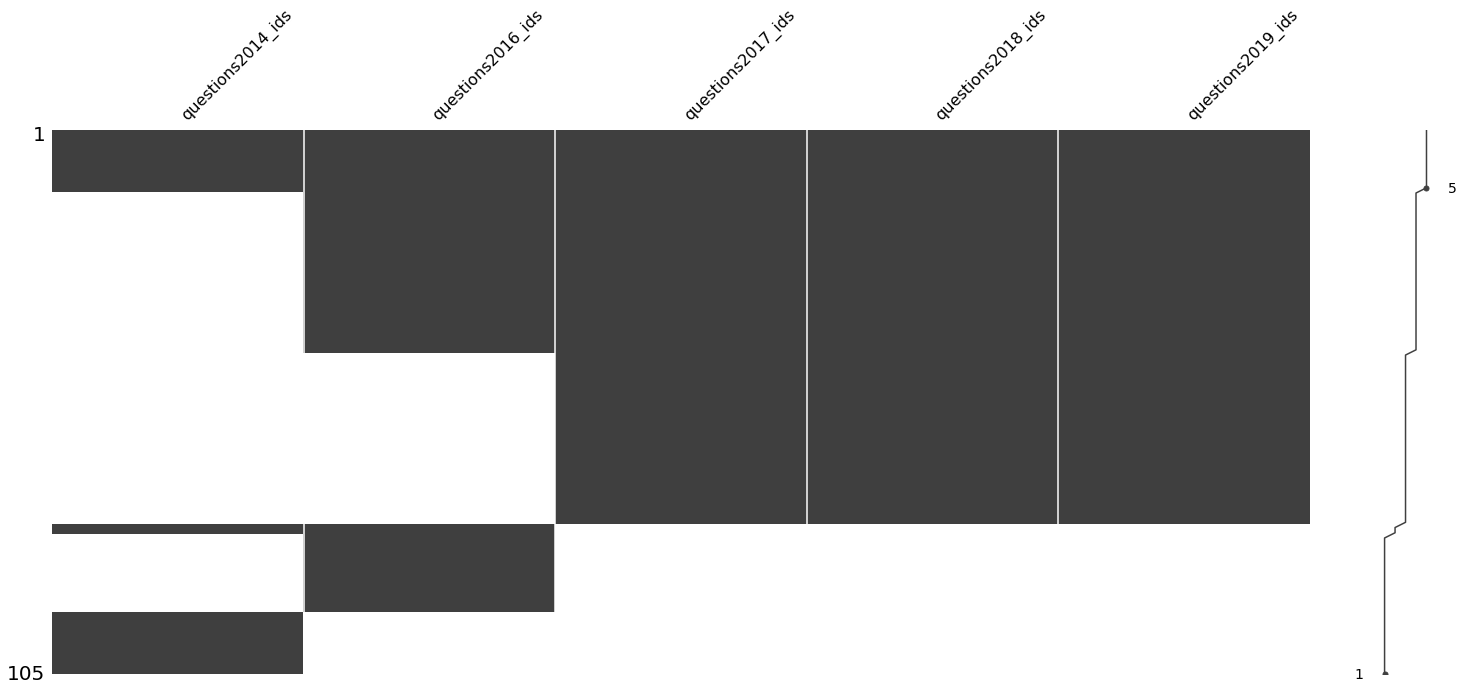

In [12]:
msno.matrix(all_questions)

It may be seen that from year 2017 the questionnaire of survey is identical, but there were noticible diffrences in surveys of year 2014 and 2016.

Preparing the main data set for further analysis.
<br>Data from tables *Answers* and *Questions* were merged.

In [13]:
data = pd.read_sql_query(
    """SELECT a.SurveyId AS year,
                             q.questionid AS question_id,
                             q.questiontext AS question,
                             a.AnswerText AS answer,
                             a.UserID AS user_id
                             FROM Answer AS a
                             JOIN Question AS q
                             ON a.QuestionID = q.questionid;""",
    conn,
)

data.head()

year  question_id           question answer  user_id
0  2014            1  What is your age?     37        1
1  2014            1  What is your age?     44        2
2  2014            1  What is your age?     32        3
3  2014            1  What is your age?     31        4
4  2014            1  What is your age?     31        5

Getting data about null values in each column and data types.
It may be seen that were is no null values in this data set, the reason behind is that missing rows were filled with value -1.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236898 entries, 0 to 236897
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   year         236898 non-null  int64 
 1   question_id  236898 non-null  int64 
 2   question     236898 non-null  object
 3   answer       236898 non-null  object
 4   user_id      236898 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 9.0+ MB


Previously, it was highlighted that part of questions were repeated in more than one survey. Further actions are taken in order to find those questions and count their recurrence.

In [15]:
unique_questions = data.groupby(["year", "question"]).agg(
    unique=("question", "nunique")
)

unique_questions.reset_index(inplace=True)

unique_questions.head()

year                                           question  unique
0  2014                   Any additional notes or comments       1
1  2014                             Are you self-employed?       1
2  2014  Do you feel that your employer takes mental he...       1
3  2014    Do you have a family history of mental illness?       1
4  2014  Do you know the options for mental health care...       1

In [16]:
repeating_questions = (
    (unique_questions["question"].value_counts())
    .to_frame()
    .rename(columns={"question": "repetition_num"})
)

repeating_questions.sample(5)

repetition_num
Describe the conversation you had with your pre...               3
Describe the conversation you had with your emp...               3
Has being identified as a person with a mental ...               3
Has your employer ever formally discussed menta...               4
Does your employer offer resources to learn mor...               4

In [17]:
repeating5times = repeating_questions[repeating_questions["repetition_num"] == 5]
repeating5times

repetition_num
Does your employer provide mental health benefi...               5
What country do you live in?                                     5
What is your gender?                                             5
Do you have a family history of mental illness?                  5
Is your anonymity protected if you choose to ta...               5
Have you ever sought treatment for a mental hea...               5
How many employees does your company or organiz...               5
Would you bring up a mental health issue with a...               5
What is your age?                                                5
Is your employer primarily a tech company/organ...               5
Are you self-employed?                                           5
If you live in the United States, which state o...               5

In [18]:
print(
    f"{len(repeating5times)} questions were repeated in surveys of year 2014, 2016, 2017, 2018, 2019."
)

12 questions were repeated in surveys of year 2014, 2016, 2017, 2018, 2019.


In [19]:
repeating4times = repeating_questions[repeating_questions["repetition_num"] >= 4]
repeating4times

repetition_num
Does your employer provide mental health benefi...               5
What country do you live in?                                     5
What is your gender?                                             5
Do you have a family history of mental illness?                  5
Is your anonymity protected if you choose to ta...               5
Have you ever sought treatment for a mental hea...               5
How many employees does your company or organiz...               5
Would you bring up a mental health issue with a...               5
What is your age?                                                5
Is your employer primarily a tech company/organ...               5
Are you self-employed?                                           5
If you live in the United States, which state o...               5
Do you currently have a mental health disorder?                  4
Were you aware of the options for mental health...               4
Do you know the options for mental health care ...               4
If you have been diagnosed or treated for a men...               4
What country do you work in?                                     4
Have you observed or experienced an unsupportiv...               4
Would you be willing to bring up a physical hea...               4
How willing would you be to share with friends ...               4
If a mental health issue prompted you to reques...               4
Has your employer ever formally discussed menta...               4
Have your observations of how another individua...               4
Was your anonymity protected if you chose to ta...               4
Have your previous employers provided mental he...               4
What US state or territory do you work in?                       4
Have you had a mental health disorder in the past?               4
Have you ever been diagnosed with a mental heal...               4
If you have a mental health disorder, how often...               4
Do you know local or online resources to seek h...               4
Is your primary role within your company relate...               4
Do you have previous employers?                                  4
If you have a mental health disorder, how often...               4
If yes, what percentage of your work time (time...               4
Would you feel comfortable discussing a mental ...               4
Did your previous employers provide resources t...               4
Do you have medical coverage (private insurance...               4
Does your employer offer resources to learn mor...               4
Do you believe your productivity is ever affect...               4
Would you feel comfortable discussing a mental ...               4
If you have been diagnosed or treated for a men...               4
Would you have been willing to discuss your men...               4
Did your previous employers ever formally discu...               4

In [20]:
print(
    f"{len(repeating4times)} questions were repeated in surveys of year 2016, 2017, 2018, 2019."
)

43 questions were repeated in surveys of year 2016, 2017, 2018, 2019.


It may be seen that there are only 12 questions, which recurred 5 times, meaning every year the survey was conducted, those questions are mostly focussed on general data about participants and, from my point of view, not suitable for an explatory data analysis. 
<br>On the other hand, 43 questions recurred in the survey of year 2016 - 2019 and they covered wider spectre of topics, related to mental health. I am thinking about analysing only repeated questions from year 2016 - 2019 as it would lead to more consistent analysis of the topic. But before that, I will look into some statistical data in order to justify my decision.

In [21]:
# number of participants from 2016

participants4 = pd.read_sql_query(
    """SELECT
                                    COUNT(DISTINCT UserID) AS Participants
                                    FROM Answer
                                    WHERE SurveyID >= 2016""",
    conn,
)

p1 = participants4["Participants"].item()

print(f"Number of participants from year 2016 - {p1}.")

Number of participants from year 2016 - 2958.


In [22]:
# total number of participants

participants_total = pd.read_sql_query(
    """SELECT
                                    COUNT(DISTINCT UserID) AS Participants
                                    FROM Answer""",
    conn,
)

p2 = participants_total["Participants"].item()

print(f"Total number of participants - {p2}.")

Total number of participants - 4218.


In [23]:
ans2016 = pd.read_sql_query(
    """SELECT COUNT(*) AS Total_answers
                             FROM Answer
                             WHERE SurveyID >= 2016""",
    conn,
)

a1 = ans2016["Total_answers"].item()

print(f"Number of answers in survey from 2016 - {a1}.")

Number of answers in survey from 2016 - 204138.


In [24]:
ans_total = pd.read_sql_query(
    """SELECT COUNT(*) AS Total_answers
                             FROM Answer""",
    conn,
)

a2 = ans_total["Total_answers"].item()

print(f"Total number of answers in survey - {a2}.")

Total number of answers in survey - 236898.


In [25]:
data_saved = round(a1 / a2 * 100, 2)

print(f"{data_saved} % of data saved if only surveys from 2016 were chosen.")

86.17 % of data saved if only surveys from 2016 were chosen.


It seems that decision not to analyse data from 2014 is valid, because:
* bigger part of data will be saved;
* as survey was not conducted on 2015, analysis would not be consistent if data from 2014 were chosen;
* questions in later surveys are more linked together.

Data frame with data from year 2016 - 2019 is prepared, repeated questions are filtered.

In [26]:
mh_data_from_2016 = data[data["year"] >= 2016].copy()
mh_data_from_2016.head()

year  question_id           question answer  user_id
32760  2016            1  What is your age?     39     1261
32761  2016            1  What is your age?     29     1262
32762  2016            1  What is your age?     38     1263
32763  2016            1  What is your age?     43     1264
32764  2016            1  What is your age?     43     1265

In [27]:
def filter_questions(question: str) -> str:
    return question in [q for q in repeating4times.index]


filtered_data = mh_data_from_2016[
    mh_data_from_2016["question"].apply(filter_questions)
].copy()
filtered_data.head()

year  question_id           question answer  user_id
32760  2016            1  What is your age?     39     1261
32761  2016            1  What is your age?     29     1262
32762  2016            1  What is your age?     38     1263
32763  2016            1  What is your age?     43     1264
32764  2016            1  What is your age?     43     1265

In [28]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127194 entries, 32760 to 218724
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   year         127194 non-null  int64 
 1   question_id  127194 non-null  int64 
 2   question     127194 non-null  object
 3   answer       127194 non-null  object
 4   user_id      127194 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 5.8+ MB


#### DATA CLEANING OF ANSWERS

Most frequent answers were filtered:

In [29]:
most_frequent_ans = (
    filtered_data.groupby("answer")
    .agg(frequence=("answer", "count"))
    .sort_values("frequence", ascending=False)
)
most_frequent_ans.head(10)

frequence
answer                             
-1                            28054
No                            14526
Yes                           12939
1                              8534
I don't know                   6855
Maybe                          4940
0                              4870
United States of America       3725
None did                       3508
Not applicable to me           2497

It may be seen that most of answers are verbal, but there some numeric values, which are not related with age.
<br>According to data description:
* value '0' stands for 'No';
* value '1' stands for 'Yes';
* value '-1' stands for missing or not provided answers.

<br>Numeric values '0' and '1' will be replaced with respective verbal values.

In [30]:
filtered_data["answer"].replace({"0": "No", "1": "Yes"}, inplace=True)

In [31]:
most_frequent_ans = (
    filtered_data.groupby("answer")
    .agg(frequence=("answer", "count"))
    .sort_values("frequence", ascending=False)
)
most_frequent_ans.head(10)

frequence
answer                             
-1                            28054
Yes                           21473
No                            19396
I don't know                   6855
Maybe                          4940
United States of America       3725
None did                       3508
Not applicable to me           2497
Some did                       2165
Male                           1839

It may be seen that a lot of answers are still missing or not provided.

In [32]:
missing_data = most_frequent_ans[most_frequent_ans.index == "-1"]["frequence"].item()
all_data = len(filtered_data)

# percentage of missing values
nan_per = round(missing_data / all_data * 100, 2)
print(f"{nan_per} % of answers are missing.")

22.06 % of answers are missing.


In order to understand, why such a noticible part of answers is missing, questions with most missing answers were filtered.

In [33]:
mask_missing_values = filtered_data["answer"] == "-1"
most_missing_values = (
    filtered_data[mask_missing_values]
    .groupby(["question", "answer"])
    .agg(frequence=("answer", "count"))
    .sort_values("frequence", ascending=False)
)
most_missing_values.head(10)

frequence
question                                           answer           
If yes, what percentage of your work time (time... -1           2591
If you have been diagnosed or treated for a men... -1           2454
Do you believe your productivity is ever affect... -1           2454
Do you have medical coverage (private insurance... -1           2454
Do you know local or online resources to seek h... -1           2454
If you have been diagnosed or treated for a men... -1           2454
Is your primary role within your company relate... -1           1387
If you live in the United States, which state o... -1           1106
Have your observations of how another individua... -1           1103
What US state or territory do you work in?         -1           1087

In my opinion, most values are missing due to lack of knowledge or unwillingness to answer, as a result, I decided not include these further analysis of data.

Most frequent answers after data filtering:

In [34]:
filtered_data = filtered_data[filtered_data["answer"] != "-1"]
most_frequent_ans = (
    filtered_data.groupby("answer")
    .agg(frequence=("answer", "count"))
    .sort_values("frequence", ascending=False)
)
most_frequent_ans.head()

frequence
answer                             
Yes                           21473
No                            19396
I don't know                   6855
Maybe                          4940
United States of America       3725

In [35]:
num_rows = len(filtered_data)

print(f"{num_rows} rows are left after filtering data.")

99140 rows are left after filtering data.


In [36]:
data = filtered_data.copy()

#### CLEANING AGE DATA

In [37]:
# preparing age data set from question 1 answers
age_data = data[data["question_id"] == 1]
age_data = age_data.drop(columns=["question_id", "question"])
age_data.rename(columns={"answer": "age"}, inplace=True)

# dropping false values
age_data = age_data[age_data["age"] != "No"]

# changing data type
age_data["age"] = age_data["age"].astype("int64")

age_data.head()

year  age  user_id
32760  2016   39     1261
32761  2016   29     1262
32762  2016   38     1263
32763  2016   43     1264
32764  2016   43     1265

Visual representation of age data and outliers:

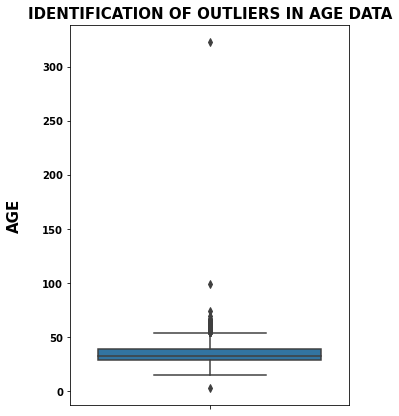

In [38]:
fig, axes = plt.subplots(figsize=(5, 7))
sns.boxplot(data=age_data, y=age_data["age"])
plt.ylabel("AGE", size=15, labelpad=20, fontweight="bold")
plt.title("IDENTIFICATION OF OUTLIERS IN AGE DATA", size=15, weight="bold")
plt.yticks(fontweight="bold");

From the plot it may be seen that were are some unlogical values in age data, for example, age is above 300.
<br>Further age data exploration:

In [39]:
age_data["age"].describe()

count    2955.000000
mean       34.709645
std         9.910378
min         3.000000
25%        29.000000
50%        33.000000
75%        39.000000
max       323.000000
Name: age, dtype: float64

Min and max values are clearly erroneous.

In [40]:
age_data["age"].unique()

array([ 39,  29,  38,  43,  42,  30,  37,  44,  28,  34,  35,  52,  32,
        25,  31,  26,  33,  27,  36,  40,  46,  41,  45,  19,  21,  24,
        17,  23,  22,  51,  48,  55,  50,  49,  20,  54,  47,  56,  57,
        63,  99,  61, 323,  62,  53,  58,   3,  66,  59,  15,  65,  74,
        70,  18,  64,  60,  67], dtype=int64)

Working age in USA, which is location of living for most of respondents, is from 14 to 64, in order not to lose more data, values that are above 80 will be changed to 80 and values lower than 14 will be replaced with 14.
<br>Source: https://data.oecd.org/pop/working-age-population.htm

In [41]:
ages_convert14 = age_data[age_data["age"] <= 14]
ages_convert80 = age_data[age_data["age"] >= 80]

# replacing values in the age_data dataset
mask_age_14 = age_data["age"].isin(ages_convert14["age"])
mask_age_80 = age_data["age"].isin(ages_convert80["age"])

age_data["age"][mask_age_14] = 14
age_data["age"][mask_age_80] = 80

age_data["age"].describe()

count    2955.000000
mean       34.624704
std         8.358682
min        14.000000
25%        29.000000
50%        33.000000
75%        39.000000
max        80.000000
Name: age, dtype: float64

#### CLEANING GENDER DATA

Uniques values:

In [42]:
# preparing gender data set from question 2 answers

gender_data = data[data["question_id"] == 2]
gender_data = gender_data.drop(columns=["question_id", "question"])

# coverting answers to upper case
gender_data["answer"] = gender_data["answer"].apply(lambda x: x.upper())

# renaming columns
gender_data.rename(columns={"answer": "gender"}, inplace=True)

gender_data["gender"].unique()

array(['MALE', 'FEMALE', 'BIGENDER', 'NON-BINARY',
       'FEMALE ASSIGNED AT BIRTH', 'FM', 'TRANSITIONED, M2F',
       'GENDERFLUID (BORN FEMALE)', 'OTHER/TRANSFEMININE',
       'FEMALE OR MULTI-GENDER FEMME', 'ANDROGYNOUS',
       'MALE 9:1 FEMALE, ROUGHLY', 'OTHER', 'NB MASCULINE',
       'NONE OF YOUR BUSINESS', 'GENDERQUEER', 'HUMAN', 'GENDERFLUID',
       'ENBY', 'GENDERQUEER WOMAN', 'MTF', 'QUEER', 'AGENDER', 'FLUID',
       'MALE/GENDERQUEER', 'NONBINARY', 'UNICORN', 'MALE (TRANS, FTM)',
       'GENDERFLUX DEMI-GIRL', 'FEMALE-BODIED; NO FEELINGS ABOUT GENDER',
       'AFAB', 'TRANSGENDER WOMAN', 'MALE/ANDROGYNOUS',
       'UHHHHHHHHH FEM GENDERQUEER?', 'GOD KING OF THE VALAJAR',
       'AGENDER/GENDERFLUID', 'MALE-ISH', 'SOMETIMES', 'WOMAN-IDENTIFIED',
       'CONTEXTUAL', 'NON BINARY', 'GENDERQUEER DEMIGIRL',
       'GENDERQUEER/NON-BINARY', 'FEMALE-ISH', '\\-', 'TRANS WOMAN',
       'TRANSFEMININE', 'NONE', 'OSTENSIBLY MALE',
       'MALE (OR FEMALE, OR BOTH)', 'TRANS MAN', '

It was decided to change values that are not 'male' or 'female' with 'other'.
<br>Uniques values after data cleaning:

In [43]:
# changing answers to other if not fename/male
gender_data.loc[
    (gender_data["gender"] != "MALE") & (gender_data["gender"] != "FEMALE"), "gender"
] = "OTHER"
gender_data["gender"].unique()

array(['MALE', 'FEMALE', 'OTHER'], dtype=object)

Further data cleaning will be performed in EDA if needed.

******************************************************************************************************************************
### EXPLORATORY DATA ANALYSIS
*******************************************************************************************************************************

#### MAP VISUALIZATION OF RESIDENCE OF SURVEY PARTICIPANTS 

In [44]:
# preparing residence data set from question 3 answers
country_data = data[data["question_id"] == 3]
country_data = country_data.drop(columns=["question_id", "question"])
country_data.rename(columns={"answer": "country"}, inplace=True)
country_data.head()

year                   country  user_id
35626  2016            United Kingdom     1261
35627  2016  United States of America     1262
35628  2016            United Kingdom     1263
35629  2016            United Kingdom     1264
35630  2016  United States of America     1265

In [45]:
# aggregating count of residence countries of participants
freq_country = (
    country_data.groupby("country")
    .agg(count=("country", "count"))
    .sort_values("count", ascending=False)
)
freq_country.reset_index(inplace=True)

In [46]:
import plotly.graph_objects as go

df = freq_country

fig = go.Figure(
    data=go.Choropleth(
        locations=df["country"].unique().tolist(),  # Spatial coordinates
        z=df["count"],  # Data to be color-coded
        locationmode="country names",  # set of locations match entries in `locations`
        colorscale="Blues",
        colorbar_title="NUMBER OF<BR>PARTICIPANTS",
    )
)

fig.update_layout(
    title_text="DISTRIBUTION OF SURVEY PARTICIPANTS IN THE WORLD",
    autosize=True,
    hovermode="closest",
    margin=dict(l=10, r=10, t=40, b=20),
)

fig.show()

#### COMPARISON OF LIVING AND WORKING LOCATIONS

In [47]:
# preparing work place location data set from question 50 answers
workcountry_data = data[data["question_id"] == 50]
workcountry_data = workcountry_data.drop(columns=["question_id", "question"])
workcountry_data.rename(columns={"answer": "country"}, inplace=True)

In [48]:
freq_workcountry = (
    workcountry_data.groupby("country")
    .agg(count=("country", "count"))
    .sort_values("count", ascending=False)
)
freq_workcountry.reset_index(inplace=True)
freq_workcountry.head()

country  count
0  United States of America   1872
1            United Kingdom    300
2                    Canada    122
3                   Germany     90
4               Netherlands     70

In [49]:
# 10 countries respondents most frequently live in
freq10_country = freq_country.iloc[:10, :]

In [50]:
# 10 countries respondents most frequently work in
freq10_workcountry = freq_workcountry.iloc[:10, :]

<ipython-input-51-8440498b1256>:26: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-51-8440498b1256>:27: UserWarning:

FixedFormatter should only be used together with FixedLocator



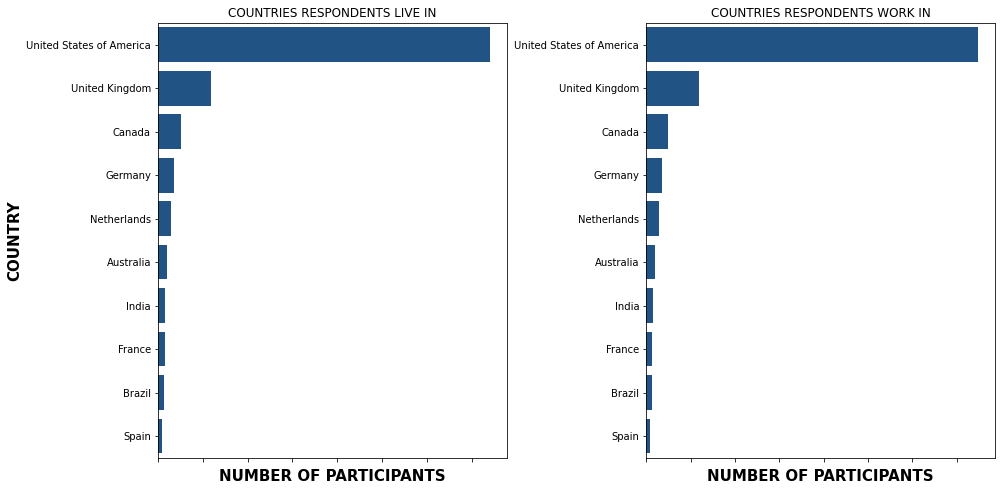

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None
)

chart0 = sns.barplot(
    ax=axes[0], x=freq10_country["count"], y=freq10_country["country"], color="#115396"
)
chart1 = sns.barplot(
    ax=axes[1],
    x=freq10_workcountry["count"],
    y=freq10_workcountry["country"],
    color="#115396",
)

axes[0].title.set_text("COUNTRIES RESPONDENTS LIVE IN")
axes[1].title.set_text("COUNTRIES RESPONDENTS WORK IN")

axes[0].set_ylabel("COUNTRY", size=15, fontweight="bold")
axes[1].set_ylabel("")

axes[0].set_xlabel("NUMBER OF PARTICIPANTS", size=15, fontweight="bold")
axes[1].set_xlabel("NUMBER OF PARTICIPANTS", size=15, fontweight="bold")

chart0.set_xticklabels(chart0.get_xticklabels(), fontweight="bold", fontsize=15)
chart1.set_xticklabels(chart0.get_xticklabels(), fontweight="bold");

It may be seen that data is very similar for both cases, meaning that participants of survey usualy work and live in the same country.

#### GENDER DISTRIBUTION BETWEEN PARTICIPANTS OF THE SURVEY

In [52]:
gender_data_agg = (
    gender_data.groupby("gender")
    .agg(count=("gender", "count"))
    .sort_values("count", ascending=False)
)

gender_data_agg

count
gender       
MALE     2052
FEMALE    777
OTHER     105

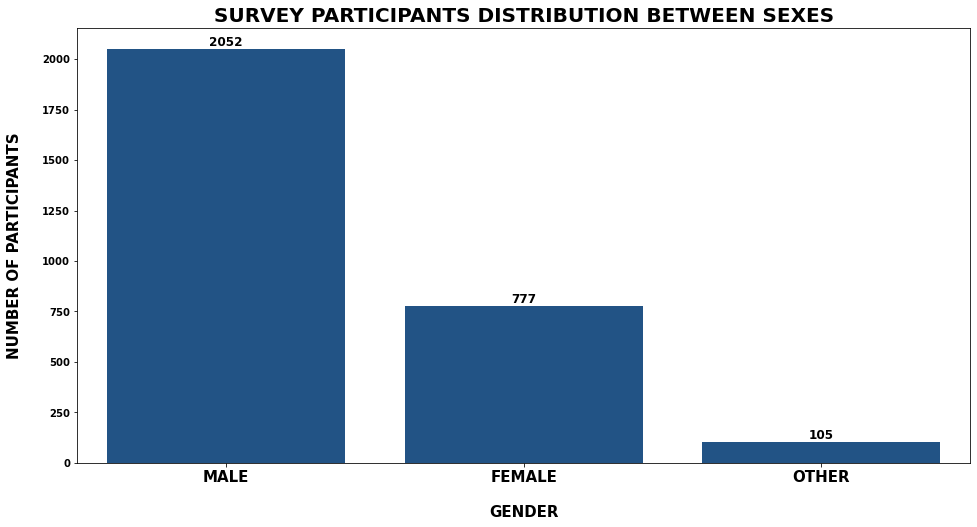

In [53]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=gender_data_agg.index, y=gender_data_agg["count"], color="#115396")
plt.xlabel("GENDER", size=15, labelpad=20, fontweight="bold")
plt.ylabel("NUMBER OF PARTICIPANTS", size=15, labelpad=20, fontweight="bold")
plt.title("SURVEY PARTICIPANTS DISTRIBUTION BETWEEN SEXES", size=20, weight="bold")
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold", rotation=0, fontsize=15)


def bar_values(ax):
    """presenting bar value on top"""
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height()
        value = f"{int(p.get_height())}"
        ax.text(
            _x,
            _y,
            value,
            verticalalignment="bottom",
            ha="center",
            fontsize=12,
            fontweight="semibold",
        )


bar_values(ax)

It may be seen that number of women in tech field is strongly dominated by the amount of male employees in this field.

#### GENDER DISTRIBUTION THROUGH TIME

In [54]:
# year 2016 gender data
gender_data2016 = gender_data[gender_data["year"] == 2016]
gender_data2016 = gender_data2016.groupby("gender").agg(count=("gender", "count"))

# year 2017 gender data
gender_data2017 = gender_data[gender_data["year"] == 2017]
gender_data2017 = gender_data2017.groupby("gender").agg(count=("gender", "count"))

# year 2018 gender data
gender_data2018 = gender_data[gender_data["year"] == 2018]
gender_data2018 = gender_data2018.groupby("gender").agg(count=("gender", "count"))

# year 2019 gender data
gender_data2019 = gender_data[gender_data["year"] == 2019]
gender_data2019 = gender_data2019.groupby("gender").agg(count=("gender", "count"))

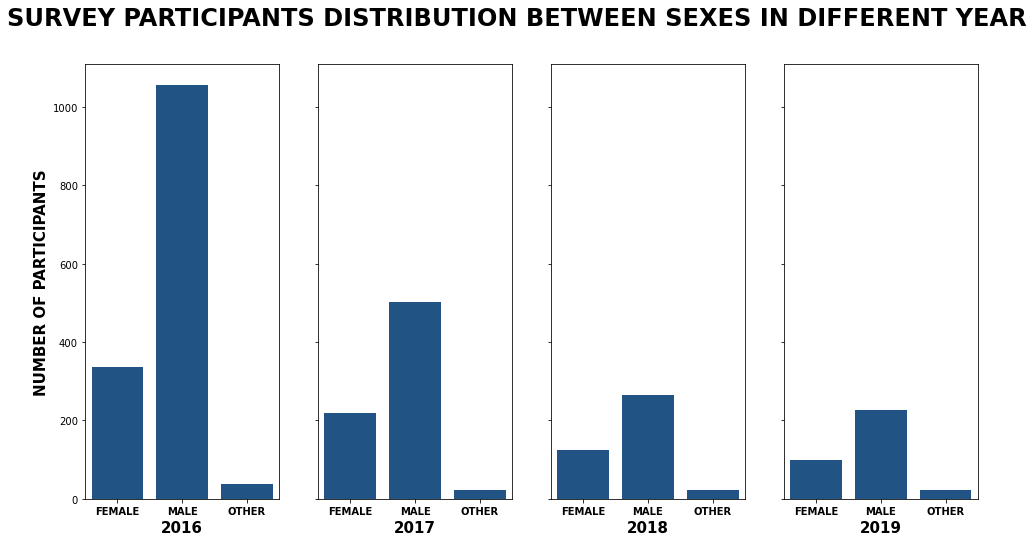

In [55]:
fig, axes = plt.subplots(1, 4, figsize=(16, 8), sharey=True)
fig.suptitle(
    "SURVEY PARTICIPANTS DISTRIBUTION BETWEEN SEXES IN DIFFERENT YEAR",
    fontsize=24,
    weight="bold",
)

chart0 = sns.barplot(
    ax=axes[0], x=gender_data2016.index, y=gender_data2016["count"], color="#115396"
)
chart1 = sns.barplot(
    ax=axes[1], x=gender_data2017.index, y=gender_data2017["count"], color="#115396"
)
chart2 = sns.barplot(
    ax=axes[2], x=gender_data2018.index, y=gender_data2018["count"], color="#115396"
)
chart3 = sns.barplot(
    ax=axes[3], x=gender_data2019.index, y=gender_data2019["count"], color="#115396"
)

axes[0].set_ylabel("NUMBER OF PARTICIPANTS", size=15, fontweight="bold")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
axes[3].set_ylabel("")

axes[0].set_xlabel("2016", size=15, fontweight="bold")
axes[1].set_xlabel("2017", size=15, fontweight="bold")
axes[2].set_xlabel("2018", size=15, fontweight="bold")
axes[3].set_xlabel("2019", size=15, fontweight="bold")

chart0.set_xticklabels(chart0.get_xticklabels(), fontweight="bold")
chart1.set_xticklabels(chart0.get_xticklabels(), fontweight="bold")
chart2.set_xticklabels(chart0.get_xticklabels(), fontweight="bold")
chart3.set_xticklabels(chart0.get_xticklabels(), fontweight="bold");

It may be seen that gap between number of women and men workers is closing, this fact corresponds to the idea that IT field is progressive and going towars gender equality.

#### AGE DISTRIBUTION

In [56]:
age_data.head()

year  age  user_id
32760  2016   39     1261
32761  2016   29     1262
32762  2016   38     1263
32763  2016   43     1264
32764  2016   43     1265

Participants were divided into 7 age groups.

In [57]:
age_groups = {
    "under 18": [i for i in range(1, 19)],
    "18 - 25": [i for i in range(18, 26)],
    "26 - 35": [i for i in range(26, 36)],
    "36 - 45": [i for i in range(36, 46)],
    "46 - 55": [i for i in range(46, 56)],
    "56 - 64": [i for i in range(56, 65)],
    "more than 64": [i for i in range(65, 100)],
}


def assign_group(x: int) -> str:
    """Assigniing int to a group from dictionary"""

    for key, values in age_groups.items():
        for item in values:
            if item == x:
                return key


age_data["age_groups"] = age_data["age"].apply(assign_group)

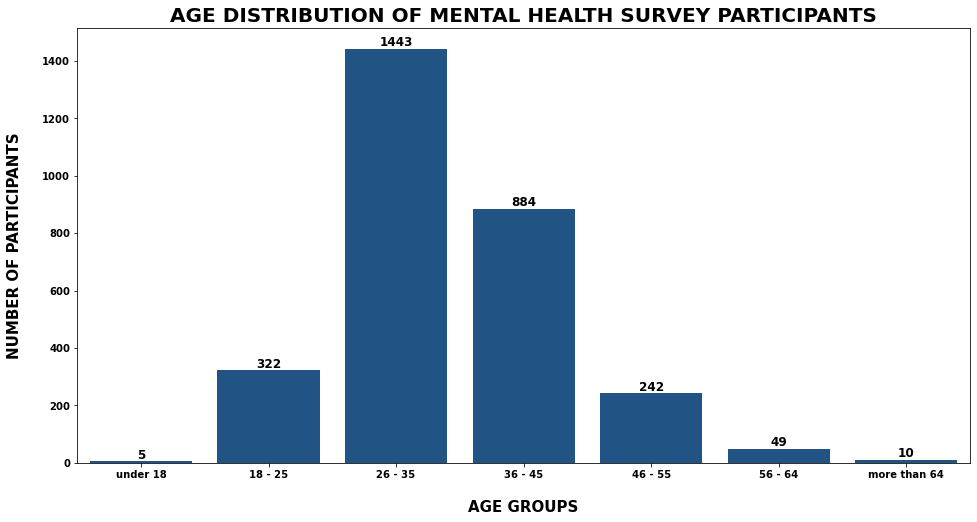

In [58]:
grouped_age = age_data.groupby("age_groups").agg(count=("age_groups", "count"))
grouped_age

order = [
    "under 18",
    "18 - 25",
    "26 - 35",
    "36 - 45",
    "46 - 55",
    "56 - 64",
    "more than 64",
]

fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=grouped_age.index, y=grouped_age["count"], color="#115396", order=order)
plt.xlabel("AGE GROUPS", size=15, labelpad=20, fontweight="bold")
plt.ylabel("NUMBER OF PARTICIPANTS", size=15, labelpad=20, fontweight="bold")
plt.title(
    "AGE DISTRIBUTION OF MENTAL HEALTH SURVEY PARTICIPANTS", size=20, weight="bold"
)
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold")
bar_values(ax);

Data shows that majority of tech field workers are young people between 26 and 35. In addtiton, a noticible part of employees are really young, there are some even younger than 18, this means that tech field is open for not only experienced and qualified, but also for inexperienced and young individuals.

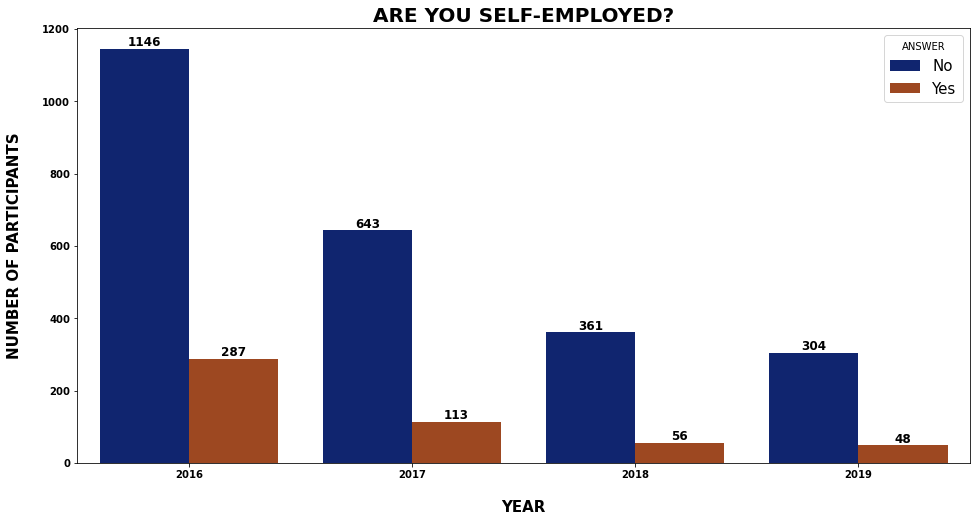

In [59]:
empl_data = data[data["question_id"] == 5]

empl_data = empl_data.groupby(["year", "answer"]).agg(count=("answer", "count"))

empl_data.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x="year", y="count", hue="answer", data=empl_data, palette="dark")
plt.xlabel("YEAR", size=15, labelpad=20, fontweight="bold")
plt.ylabel("NUMBER OF PARTICIPANTS", size=15, labelpad=20, fontweight="bold")
plt.title(
    "ARE YOU SELF-EMPLOYED?",
    size=20,
    weight="bold",
)
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold")
plt.legend(loc="upper right", title="ANSWER", fontsize=15)
bar_values(ax);

It may be seen that part of self-employed people is increasing in tech field through time, it might be determined by decreasing rate of participation in the survey or maybe improving conditions of self-employement.

In [60]:
company_data = (
    data[data["question_id"] == 9].groupby("answer").agg(count=("answer", "count"))
)

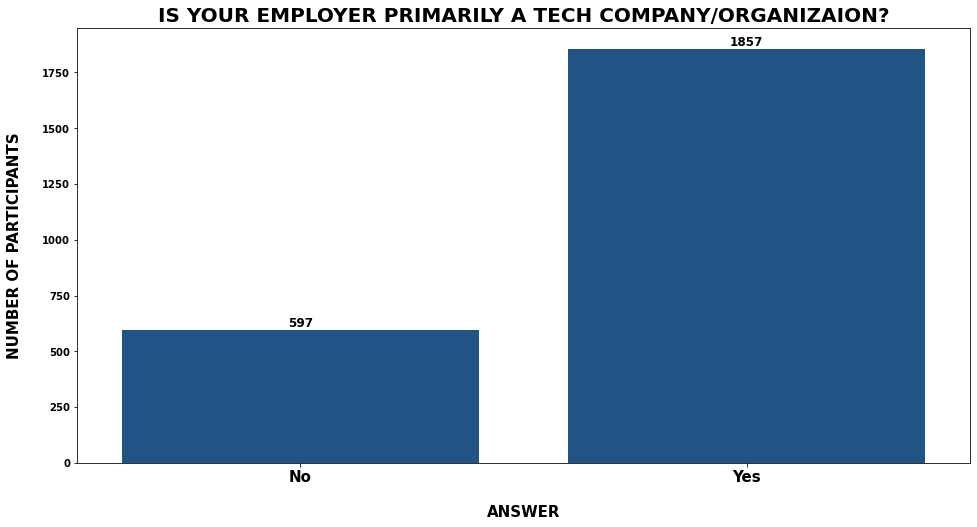

In [61]:
company_data = (
    data[data["question_id"] == 9].groupby("answer").agg(count=("answer", "count"))
)

fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=company_data.index, y=company_data["count"], color="#115396")
plt.xlabel("ANSWER", size=15, labelpad=20, fontweight="bold")
plt.ylabel("NUMBER OF PARTICIPANTS", size=15, labelpad=20, fontweight="bold")
plt.title(
    "IS YOUR EMPLOYER PRIMARILY A TECH COMPANY/ORGANIZAION?", size=20, weight="bold"
)
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold", fontsize=15)
bar_values(ax);

Majority of respondents claimed to be working in the company of tech field, however, a noticible part of respondents answered 'No' to this question, it may be related to increasing importance of technologies in other fields - some companies in other fields also have their IT departaments.

#### ANALYSIS OF COMPANY SIZE

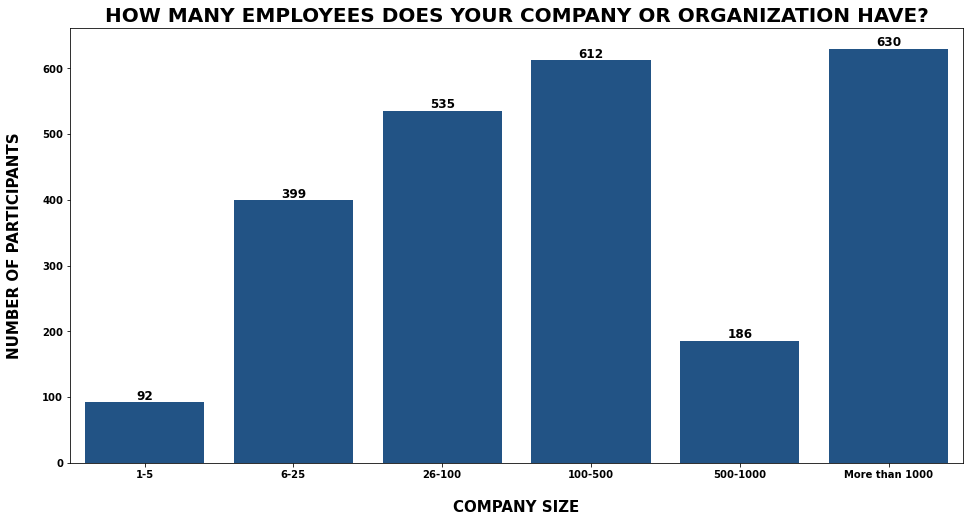

In [62]:
# aggregating data about company size from question 8 answers
company_size_data = (
    data[data["question_id"] == 8].groupby("answer").agg(count=("answer", "count"))
)

order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]

fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(
    x=company_size_data.index,
    y=company_size_data["count"],
    color="#115396",
    order=order,
)
plt.xlabel("COMPANY SIZE", size=15, labelpad=20, fontweight="bold")
plt.ylabel("NUMBER OF PARTICIPANTS", size=15, labelpad=20, fontweight="bold")
plt.title(
    "HOW MANY EMPLOYEES DOES YOUR COMPANY OR ORGANIZATION HAVE?", size=20, weight="bold"
)
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold")
bar_values(ax);

It may be seen that companies of large and average size dominate in the tech industry.

#### MENTAL HEALTH STATE ANALYSIS

In [63]:
# aggregating data about metal health disorders from question 33 answers
q33_data = data[data["question_id"] == 33].drop(columns=["year"])

# merging data sets about questions 33 and 1 together
q33_age_data = pd.merge(
    q33_data,
    age_data,
    how="inner",
    left_on=q33_data["user_id"],
    right_on=age_data["user_id"],
)
q33_age_data = q33_age_data.drop(
    columns=["user_id_x", "user_id_y", "question", "question_id"]
).rename(columns={"key_0": "user_id", "answer": "q33_ans"})
q33_age_agg = q33_age_data.groupby(["q33_ans", "age_groups"]).agg(
    count=("q33_ans", "count")
)
q33_age_agg.reset_index(inplace=True)

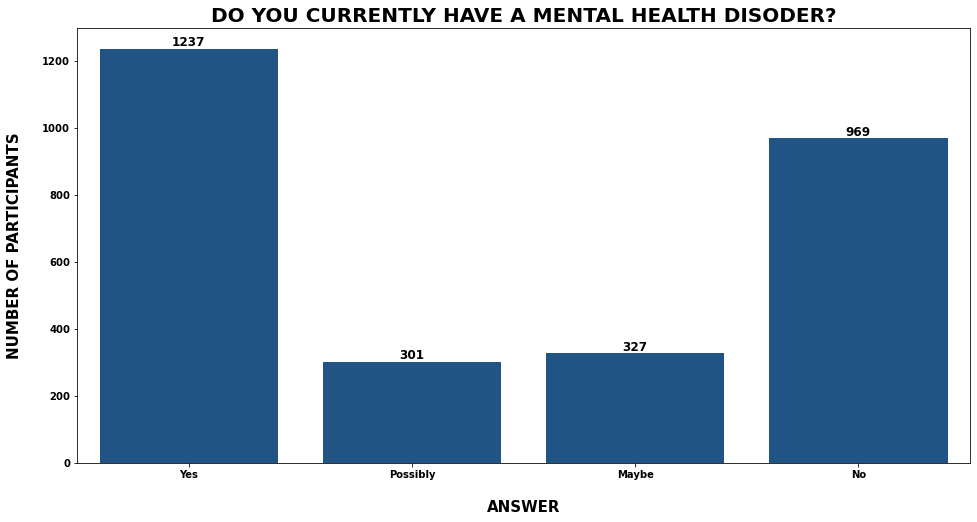

In [64]:
q33_data_agg = q33_data.groupby("answer").agg(count=("answer", "count"))

order = ["Yes", "Possibly", "Maybe", "No"]

fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=q33_data_agg.index, y=q33_data_agg["count"], color="#115396", order=order)
plt.xlabel("ANSWER", size=15, labelpad=20, fontweight="bold")
plt.ylabel("NUMBER OF PARTICIPANTS", size=15, labelpad=20, fontweight="bold")
plt.title("DO YOU CURRENTLY HAVE A MENTAL HEALTH DISODER?", size=20, weight="bold")
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold")
bar_values(ax);

It may be seen that majority of respndents claims to have mental issues of some kind. In addition, answers 'Possibly' and 'Maybe' are misleading in this case, from my point of view, these groups of answers may account for people, who are doubting about the state of their mental health, which would indicate some kind of problem in this area. It is important to stress that many respondents chose answer 'No', that means that it is possible to have great mental health even if working in stressful and competetive environment. 

In [65]:
# getting data about familly history of mental illnesses of respondents, who claim to heva mental problems
mhd = q33_data[q33_data["answer"] == "Yes"]

# data about family history of mental illness from question 6 answers
q6_data = data[data["question_id"] == 6]

# merging data sets
mhd_family_data = pd.merge(
    mhd,
    q6_data,
    how="inner",
    left_on=mhd["user_id"],
    right_on=q6_data["user_id"],
    sort=True,
)

mhd_family_data = mhd_family_data.drop(
    columns=[
        "question_id_x",
        "question_x",
        "user_id_x",
        "year",
        "question_id_y",
        "question_y",
        "user_id_y",
        "answer_x",
    ]
)

mhd_family_data.rename(columns={"key_0": "user_id", "answer_y": "answer"}, inplace=True)

mhd_family_data_agg = mhd_family_data.groupby("answer").agg(count=("answer", "count"))

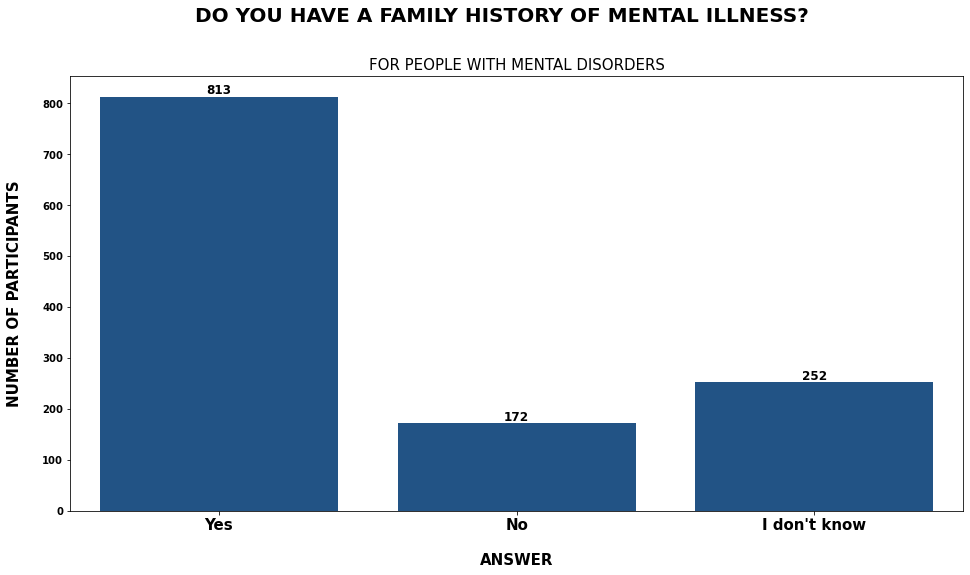

In [66]:
fig, ax = plt.subplots(figsize=(16, 8))

order = ["Yes", "No", "I don't know"]

sns.barplot(
    x=mhd_family_data_agg.index,
    y=mhd_family_data_agg["count"],
    color="#115396",
    order=order,
)
plt.xlabel("ANSWER", size=15, labelpad=20, fontweight="bold")
plt.ylabel("NUMBER OF PARTICIPANTS", size=15, labelpad=20, fontweight="bold")
plt.title("FOR PEOPLE WITH MENTAL DISORDERS", size=15)
plt.suptitle(
    "DO YOU HAVE A FAMILY HISTORY OF MENTAL ILLNESS?", size=20, weight="bold", y=1
)
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold", fontsize=15)
bar_values(ax);

It may be seen that majority of respondents, having mental problems, have a family history of mental illnesses. It raises a question, wheather mental issues occured due to stressful environment at a workplace or due to genetics and environment, while growing up, also, there may be other reasons behind mental disorders.

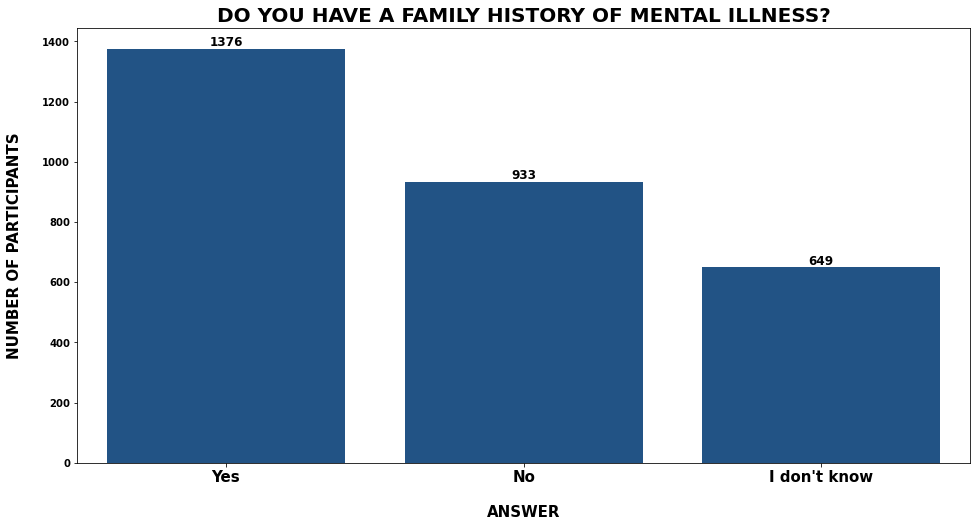

In [67]:
# getiing data about family history of mental disorders from question 6 answers
q6_data = (
    data[data["question_id"] == 6]
    .drop(columns=["question_id", "question", "year"])
    .groupby("answer")
    .agg(count=("answer", "count"))
)

fig, ax = plt.subplots(figsize=(16, 8))

order = ["Yes", "No", "I don't know"]

sns.barplot(x=q6_data.index, y=q6_data["count"], color="#115396", order=order)
plt.xlabel("ANSWER", size=15, labelpad=20, fontweight="bold")
plt.ylabel("NUMBER OF PARTICIPANTS", size=15, labelpad=20, fontweight="bold")
plt.title("DO YOU HAVE A FAMILY HISTORY OF MENTAL ILLNESS?", size=20, weight="bold")
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold", fontsize=15)
bar_values(ax);

A representation of family history of mental disorders shows a few things. Firsly, mental diseases are very common as almost half of respondets hace a case of mental disorder in their family. Secondly, a lot of people are not interested in their family members mental well-being as they answeres "I don't know" to this question, it may account for other problem that people are not willing to share problems related to mental state even with their family members.

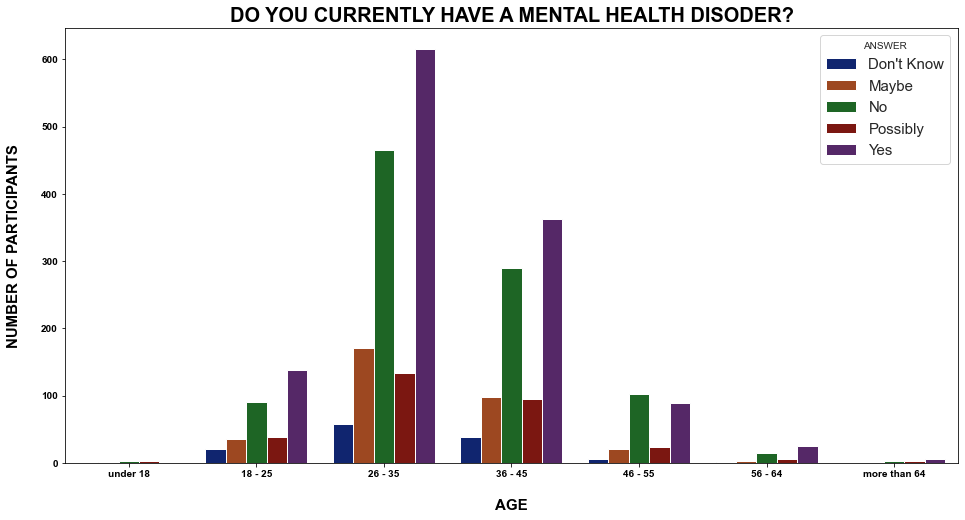

In [68]:
fig, ax = plt.subplots(figsize=(16, 8))

order = [
    "under 18",
    "18 - 25",
    "26 - 35",
    "36 - 45",
    "46 - 55",
    "56 - 64",
    "more than 64",
]

# adding horizontal gridlines
sns.set_style("whitegrid")

sns.barplot(
    x="age_groups",
    y="count",
    hue="q33_ans",
    data=q33_age_agg,
    palette="dark",
    order=order,
)
plt.xlabel("AGE", size=15, labelpad=20, fontweight="bold")
plt.ylabel("NUMBER OF PARTICIPANTS", size=15, labelpad=20, fontweight="bold")
plt.title(
    "DO YOU CURRENTLY HAVE A MENTAL HEALTH DISODER?",
    size=20,
    weight="bold",
)
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold")
plt.legend(loc="upper right", title="ANSWER", fontsize=15);

It may be seen that mental disorders are common for people of various age, in every age group there are more people, who has mental illness than people with healthy mental state. It may be also seen that numbers are proportional with group size, so we cannot claim that people between 26 and 35 are affected more by mental health problems.

In [69]:
# getting data about treatment of mental health disorders from question 7 answers

q7_data = data[data["question_id"] == 7].drop(
    columns=["question_id", "question", "year"]
)

q7_data_agg = q7_data.groupby("answer").agg(count=("answer", "count"))

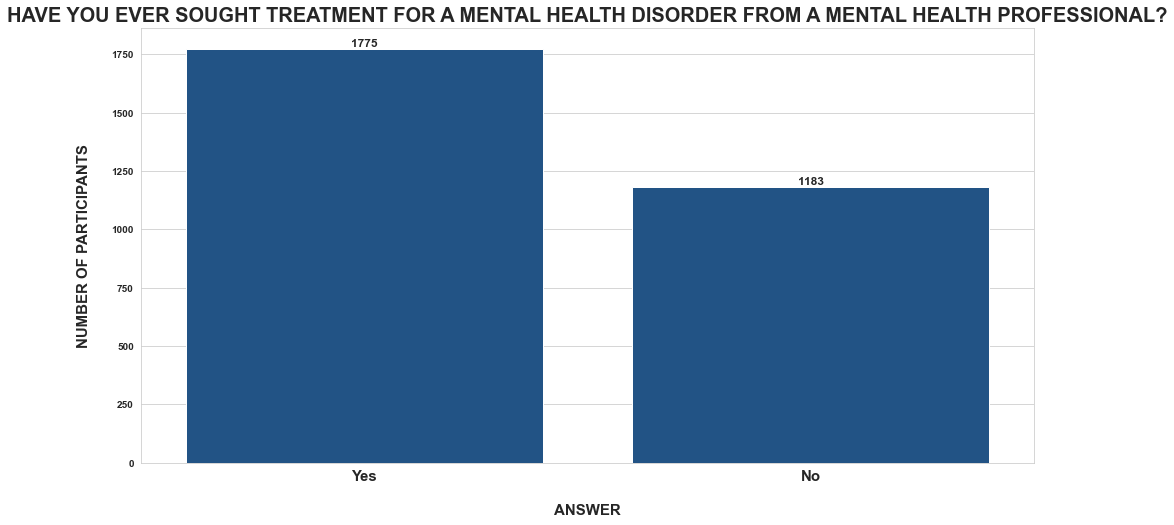

In [70]:
fig, ax = plt.subplots(figsize=(16, 8))

order = ["Yes", "No"]

sns.barplot(x=q7_data_agg.index, y=q7_data_agg["count"], color="#115396", order=order)
plt.xlabel("ANSWER", size=15, labelpad=20, fontweight="bold")
plt.ylabel("NUMBER OF PARTICIPANTS", size=15, labelpad=20, fontweight="bold")
plt.title(
    "HAVE YOU EVER SOUGHT TREATMENT FOR A MENTAL HEALTH DISORDER FROM A MENTAL HEALTH PROFESSIONAL?",
    size=20,
    weight="bold",
)
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold", fontsize=15)
bar_values(ax);

It is great news that majority of respondents trust medical workers with problems of mental health and tried to get treatment.

In [71]:
# merging data from previous question witg age data
q7_age_data = pd.merge(
    q7_data,
    age_data,
    how="inner",
    left_on=q7_data["user_id"],
    right_on=age_data["user_id"],
    sort=True,
)

q7_age_data = q7_age_data.drop(columns=["user_id_x", "user_id_y"]).rename(
    columns={"answer_x": "q7_ans", "key_0": "user_id"}
)

q7_age_data_agg = (
    q7_age_data.groupby(["answer", "age_groups"])
    .agg(count=("answer", "count"))
    .reset_index()
)

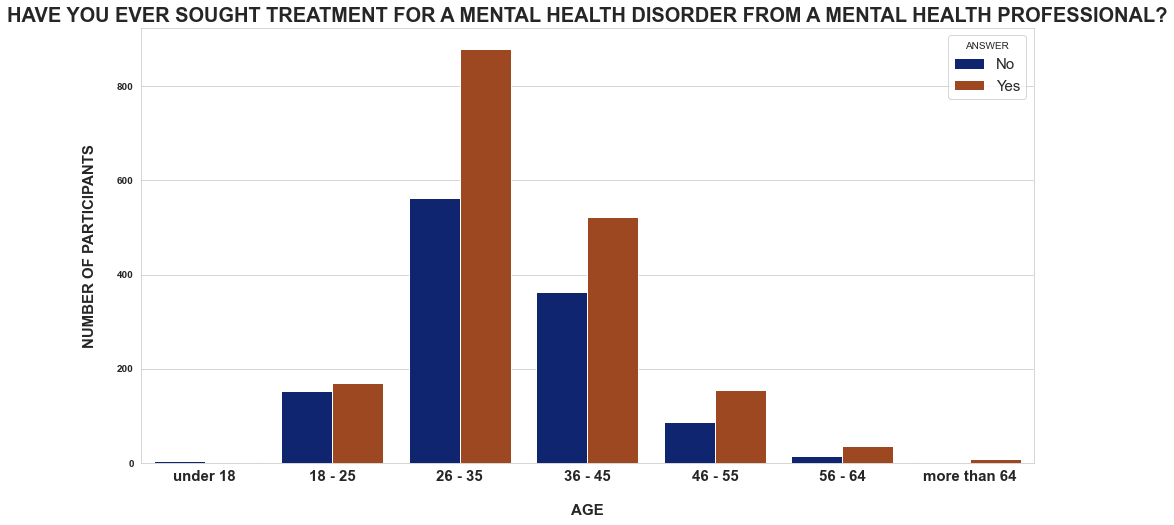

In [72]:
fig, ax = plt.subplots(figsize=(16, 8))

order = [
    "under 18",
    "18 - 25",
    "26 - 35",
    "36 - 45",
    "46 - 55",
    "56 - 64",
    "more than 64",
]

sns.barplot(
    x="age_groups",
    y="count",
    hue="answer",
    data=q7_age_data_agg,
    palette="dark",
    order=order,
)
plt.xlabel("AGE", size=15, labelpad=20, fontweight="bold")
plt.ylabel("NUMBER OF PARTICIPANTS", size=15, labelpad=20, fontweight="bold")
plt.title(
    "HAVE YOU EVER SOUGHT TREATMENT FOR A MENTAL HEALTH DISORDER FROM A MENTAL HEALTH PROFESSIONAL?",
    size=20,
    weight="bold",
)
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold", fontsize=15)
plt.legend(loc="upper right", title="ANSWER", fontsize=15);

The plot shows that people in various age groups tend to seek for treatment of mental health problems.

In [73]:
# getting data about company size of mental health disorders from question 8 answers
q8_data = data[data["question_id"] == 8].drop(columns=["question_id", "question"])

# merging data about company size and mental disorders
q8_q33_data = pd.merge(
    q8_data,
    q33_data,
    how="inner",
    left_on=q8_data["user_id"],
    right_on=q33_data["user_id"],
    sort=True,
)

q8_q33_data = q8_q33_data.drop(columns=["user_id_x", "user_id_y"]).rename(
    columns={"answer_x": "q8_ans", "answer_y": "q33_ans"}
)

q8_q33_data_agg = (
    q8_q33_data.groupby(["q8_ans", "q33_ans"])
    .agg(count=("q8_ans", "count"))
    .reset_index()
)

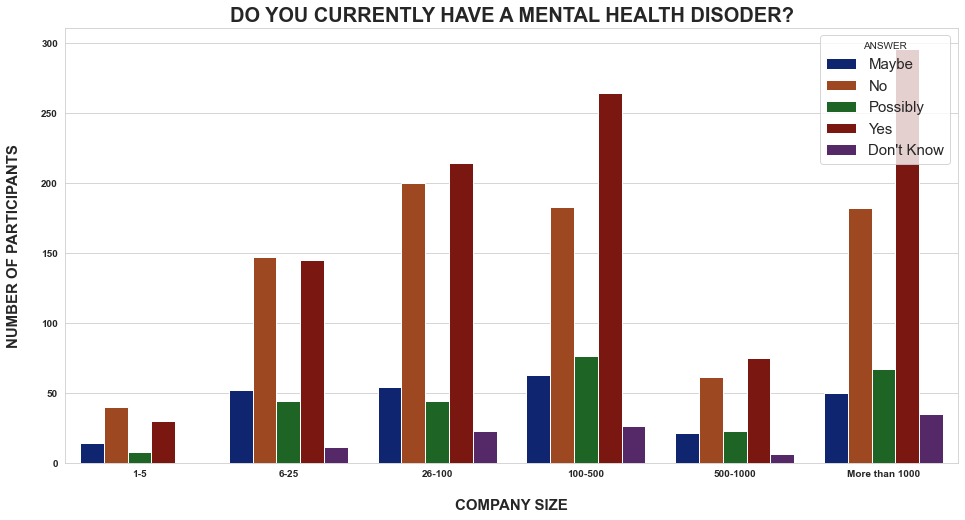

In [74]:
fig, ax = plt.subplots(figsize=(16, 8))

order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]

# adding horizontal gridlines
sns.set_style("whitegrid")

sns.barplot(
    x="q8_ans",
    y="count",
    hue="q33_ans",
    data=q8_q33_data_agg,
    palette="dark",
    order=order,
)
plt.xlabel("COMPANY SIZE", size=15, labelpad=20, fontweight="bold")
plt.ylabel("NUMBER OF PARTICIPANTS", size=15, labelpad=20, fontweight="bold")
plt.title(
    "DO YOU CURRENTLY HAVE A MENTAL HEALTH DISODER?",
    size=20,
    weight="bold",
)
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold")
plt.legend(loc="upper right", title="ANSWER", fontsize=15);

It may be seen that part of people having mental issues correlates with company size - as companies size is increasing the part of mentally affected people is increasing as well. The reason behind that may be atmosphere at work, as in smaller companies people usualy bond better that leading to better work environment.

In [75]:
# getting data about the coverage of mental health benefits from question 10 answers
q10_data = data[data["question_id"] == 10].drop(
    columns=["question", "question_id", "year"]
)

# merging data about the size of the company and mental health benefits
q8_10_data = pd.merge(
    q10_data,
    q8_data,
    how="inner",
    left_on=q10_data["user_id"],
    right_on=q8_data["user_id"],
)

q8_10_data = q8_10_data.drop(columns=["user_id_x", "user_id_y"])

q8_10_data = q8_10_data.rename(
    columns={"key_0": "user_id", "answer_x": "q10_ans", "answer_y": "q8_ans"}
)

q8_10_data_agg = q8_10_data.groupby(["q10_ans", "q8_ans"]).agg(
    count=("q8_ans", "count")
)

q8_10_data_agg.reset_index(inplace=True)

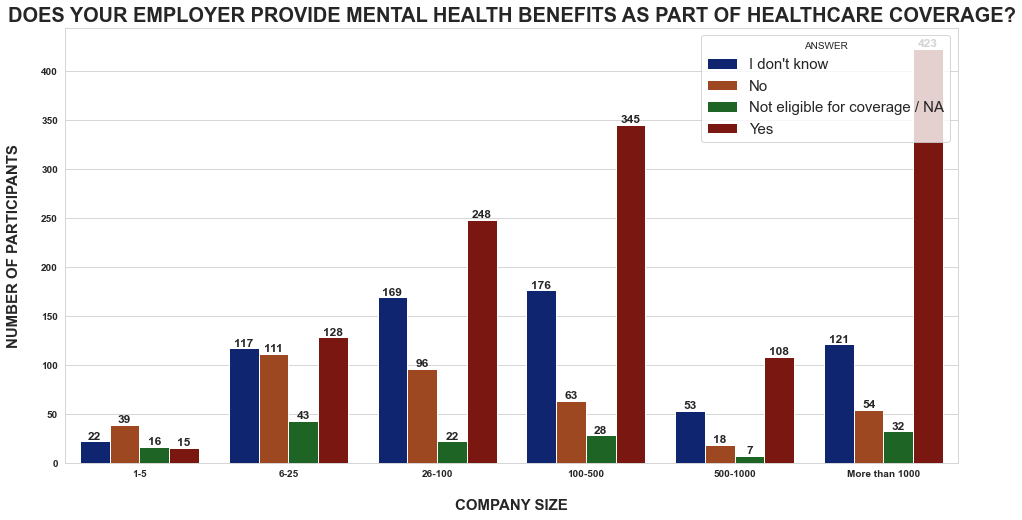

In [76]:
fig, ax = plt.subplots(figsize=(16, 8))

order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]

sns.barplot(
    x="q8_ans",
    y="count",
    hue="q10_ans",
    data=q8_10_data_agg,
    palette="dark",
    order=order,
)
plt.xlabel("COMPANY SIZE", size=15, labelpad=20, fontweight="bold")
plt.ylabel("NUMBER OF PARTICIPANTS", size=15, labelpad=20, fontweight="bold")
plt.title(
    "DOES YOUR EMPLOYER PROVIDE MENTAL HEALTH BENEFITS AS PART OF HEALTHCARE COVERAGE?",
    size=20,
    weight="bold",
)
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold")
plt.legend(loc="upper right", title="ANSWER", fontsize=15)
bar_values(ax);

It may be seen that larger companies invest more into mental health of their employees, but there are more cases of mental health disorders in these. Anyway, a surprisingly big part of respondents does not know about benefits they have, whch shows that people should be more proactive in taking care of their mental health as well.

In [77]:
# getting data about the medical leave due to mental problems from question 17 answers
q17_data = data[data["question_id"] == 17].drop(
    columns=["question", "question_id", "year"]
)

q17_data_agg = q17_data.groupby("answer").agg(count=("answer", "count"))

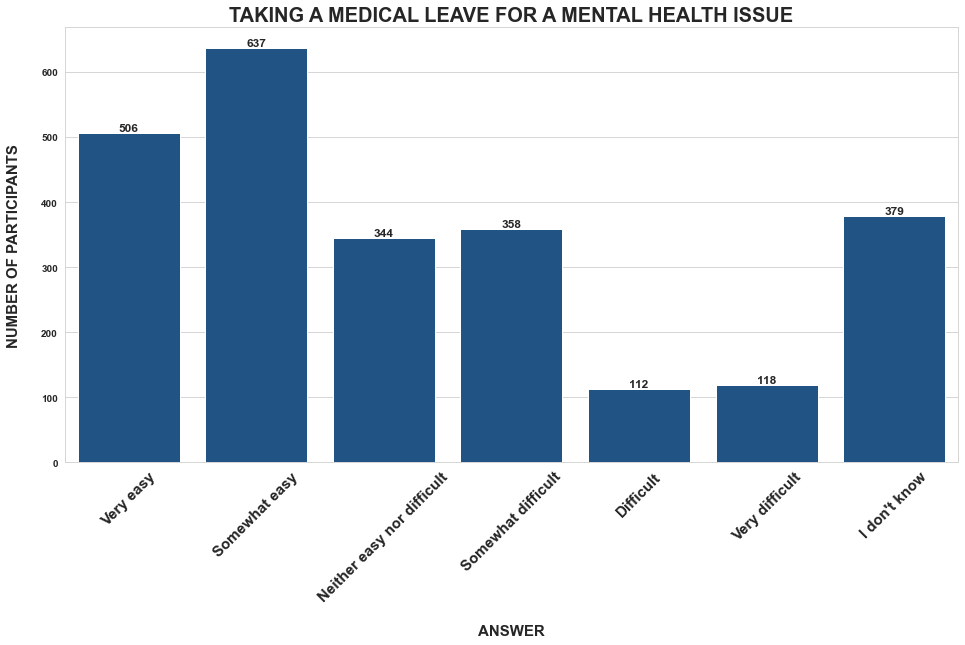

In [78]:
fig, ax = plt.subplots(figsize=(16, 8))

order = [
    "Very easy",
    "Somewhat easy",
    "Neither easy nor difficult",
    "Somewhat difficult",
    "Difficult",
    "Very difficult",
    "I don't know",
]

sns.barplot(x=q17_data_agg.index, y=q17_data_agg["count"], color="#115396", order=order)

plt.xlabel("ANSWER", size=15, labelpad=20, fontweight="bold")
plt.ylabel("NUMBER OF PARTICIPANTS", size=15, labelpad=20, fontweight="bold")
plt.title("TAKING A MEDICAL LEAVE FOR A MENTAL HEALTH ISSUE", size=20, weight="bold")
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold", fontsize=15, rotation=45)
bar_values(ax);

It is seems that most of respondents are not facing huge difficulties if medical leave due to mental issues is needed, which indicates growing empathy and mental problems not being such a stigma anymore. However, there is still a room for companies to improve. 

In [79]:
# merging data about the medical leave and the size of the company
q8_17_data = pd.merge(
    q17_data,
    q8_data,
    how="inner",
    left_on=q17_data["user_id"],
    right_on=q8_data["user_id"],
)

q8_17_data = q8_17_data.drop(columns=["user_id_x", "user_id_y"])

q8_17_data = q8_17_data.rename(
    columns={"key_0": "user_id", "answer_x": "q17_ans", "answer_y": "q8_ans"}
)

q8_17_data_agg = q8_17_data.groupby(["q17_ans", "q8_ans"]).agg(
    count=("q8_ans", "count")
)

q8_17_data_agg.reset_index(inplace=True)

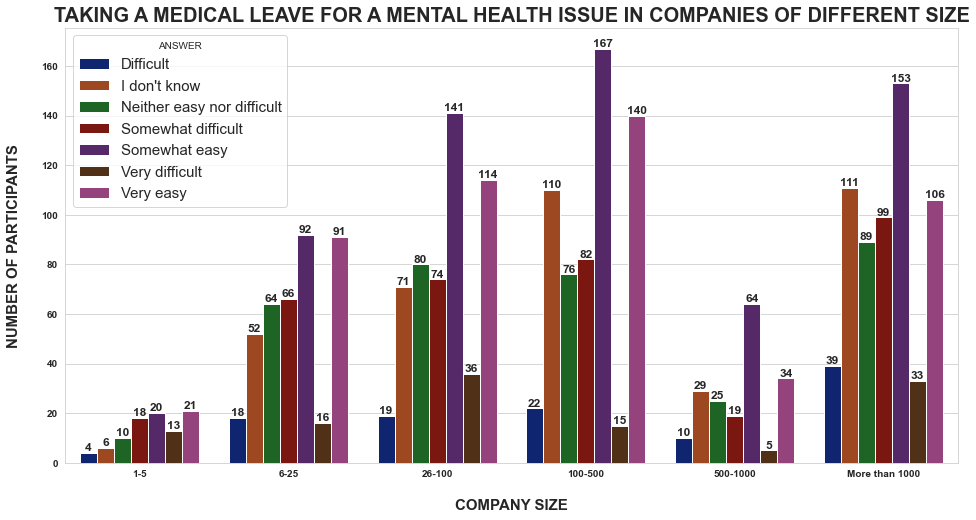

In [80]:
fig, ax = plt.subplots(figsize=(16, 8))

order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]

sns.barplot(
    x="q8_ans",
    y="count",
    hue="q17_ans",
    data=q8_17_data_agg,
    palette="dark",
    order=order,
)
plt.xlabel("COMPANY SIZE", size=15, labelpad=20, fontweight="bold")
plt.ylabel("NUMBER OF PARTICIPANTS", size=15, labelpad=20, fontweight="bold")
plt.title(
    "TAKING A MEDICAL LEAVE FOR A MENTAL HEALTH ISSUE IN COMPANIES OF DIFFERENT SIZE",
    size=20,
    weight="bold",
)
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold")
plt.legend(loc="upper left", title="ANSWER", fontsize=15)
bar_values(ax);

It may be seen that the ease ot taking medical leave dur to mental problems do not vary much with company size. It may be seen that answer 'Somewhat easy', which indicates that situation is on the right path in companies of all sizes. However, answers 'Somewhat difficult' also account for a noticible part of respondents.

In [81]:
# getting data about employees feeling comfortable discussing a mental health issue with your coworkers from question 18 answers
q18_data = data[data["question_id"] == 18].drop(
    columns=["question", "question_id", "year"]
)

q18_data_agg = q18_data.groupby("answer").agg(count=("answer", "count"))

In [82]:
# getting data about employees feeling comfortable discussing a mental health issue with your direct supervisor(s) from question 19 answers
q19_data = data[data["question_id"] == 19].drop(
    columns=["question", "question_id", "year"]
)

q19_data_agg = q18_data.groupby("answer").agg(count=("answer", "count"))

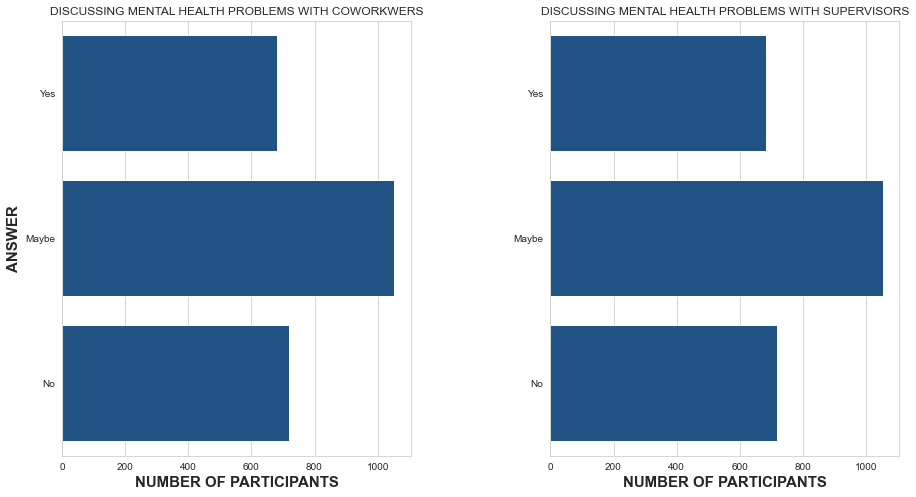

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None
)

order = ["Yes", "Maybe", "No"]

chart0 = sns.barplot(
    ax=axes[0],
    x=q18_data_agg["count"],
    y=q18_data_agg.index,
    color="#115396",
    order=order,
)
chart1 = sns.barplot(
    ax=axes[1],
    x=q19_data_agg["count"],
    y=q19_data_agg.index,
    color="#115396",
    order=order,
)

axes[0].title.set_text("DISCUSSING MENTAL HEALTH PROBLEMS WITH COWORKWERS")
axes[1].title.set_text("DISCUSSING MENTAL HEALTH PROBLEMS WITH SUPERVISORS")

axes[0].set_ylabel("ANSWER", size=15, fontweight="bold")
axes[1].set_ylabel("")

axes[0].set_xlabel("NUMBER OF PARTICIPANTS", size=15, fontweight="bold")
axes[1].set_xlabel("NUMBER OF PARTICIPANTS", size=15, fontweight="bold");

In both categories answer 'Maybe' dominates, which may be indicate that workers have never tried discussing mental issues with their coworkers or supervisors. Answers are equally distributed between 'Yes' and 'No', which are not clunclusive in this case.

In [84]:
# merging data from question 18 with the size of company data
q8_18_data = pd.merge(
    q18_data,
    q8_data,
    how="inner",
    left_on=q18_data["user_id"],
    right_on=q8_data["user_id"],
)

q8_18_data = q8_18_data.drop(columns=["user_id_x", "user_id_y"])

q8_18_data = q8_18_data.rename(
    columns={"key_0": "user_id", "answer_x": "q18_ans", "answer_y": "q8_ans"}
)

q8_18_data_agg = q8_18_data.groupby(["q18_ans", "q8_ans"]).agg(
    count=("q8_ans", "count")
)

q8_18_data_agg.reset_index(inplace=True)

In [85]:
# merging data from question 19 with the size of company data
q8_19_data = pd.merge(
    q19_data,
    q8_data,
    how="inner",
    left_on=q19_data["user_id"],
    right_on=q8_data["user_id"],
)

q8_19_data = q8_19_data.drop(columns=["user_id_x", "user_id_y"])

q8_19_data = q8_19_data.rename(
    columns={"key_0": "user_id", "answer_x": "q19_ans", "answer_y": "q8_ans"}
)

q8_19_data_agg = q8_19_data.groupby(["q19_ans", "q8_ans"]).agg(
    count=("q8_ans", "count")
)

q8_19_data_agg.reset_index(inplace=True)

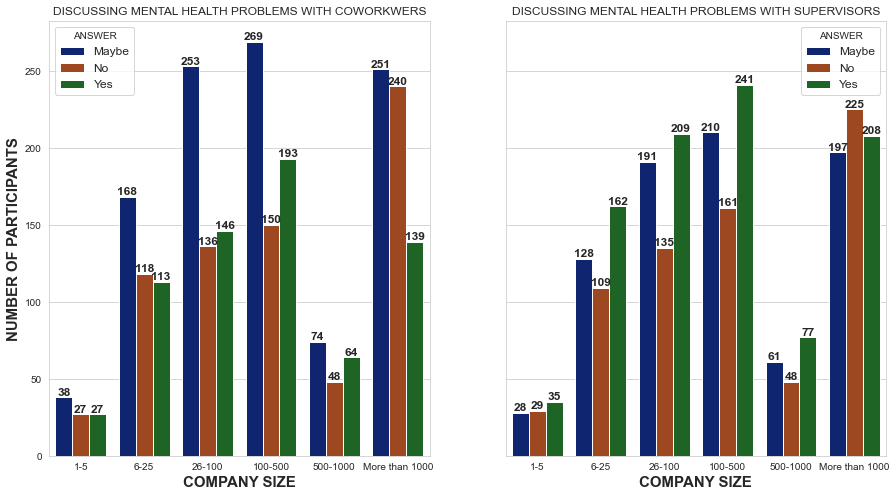

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]

chart0 = sns.barplot(
    ax=axes[0],
    x="q8_ans",
    y="count",
    hue="q18_ans",
    data=q8_18_data_agg,
    palette="dark",
    order=order,
)
chart1 = sns.barplot(
    ax=axes[1],
    x="q8_ans",
    y="count",
    hue="q19_ans",
    data=q8_19_data_agg,
    palette="dark",
    order=order,
)

axes[0].title.set_text("DISCUSSING MENTAL HEALTH PROBLEMS WITH COWORKWERS")
axes[1].title.set_text("DISCUSSING MENTAL HEALTH PROBLEMS WITH SUPERVISORS")

axes[0].set_ylabel("NUMBER OF PARTICIPANTS", size=15, fontweight="bold")
axes[1].set_ylabel("")

axes[0].set_xlabel("COMPANY SIZE", size=15, fontweight="bold")
axes[1].set_xlabel("COMPANY SIZE", size=15, fontweight="bold")

chart0.legend(loc="upper left", title="ANSWER", fontsize=12)
chart1.legend(loc="upper right", title="ANSWER", fontsize=12)
bar_values(axes[0])
bar_values(axes[1]);

It may be seen that workers are more willing to discuss mental issues with supervisors than coworkers. Also, it may be seen that majority of representatives from really large companies (having more thant 1000 employees) are not willing discuss mental problems with neither coworkers nor supervisors, which speaks about atmosphere, trust and maybe event competition in large companies.

#### WHY IS IT IMPORTANT?

In [87]:
# getting data about mental problems interference with productivity when not treated effectively from question 49 answers
q49_data = data[data["question_id"] == 49].drop(
    columns=["question", "question_id", "year"]
)

q49_data_agg = q49_data.groupby("answer").agg(count=("answer", "count"))

In [88]:
# getting data about mental problems interference with productivity when treated effectively from question 48 answers

q48_data = data[data["question_id"] == 48].drop(
    columns=["question", "question_id", "year"]
)

q48_data_agg = q48_data.groupby("answer").agg(count=("answer", "count"))

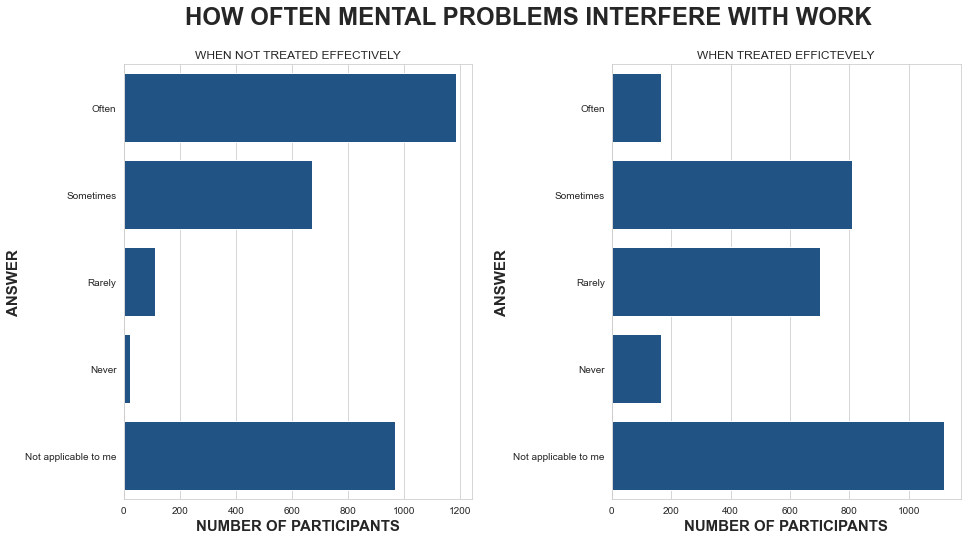

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None
)

fig.suptitle(
    "HOW OFTEN MENTAL PROBLEMS INTERFERE WITH WORK",
    fontsize=24,
    weight="bold",
)

order = ["Often", "Sometimes", "Rarely", "Never", "Not applicable to me"]

chart0 = sns.barplot(
    ax=axes[0],
    x=q49_data_agg["count"],
    y=q49_data_agg.index,
    color="#115396",
    order=order,
)
chart1 = sns.barplot(
    ax=axes[1],
    x=q48_data_agg["count"],
    y=q48_data_agg.index,
    color="#115396",
    order=order,
)

axes[0].title.set_text("WHEN NOT TREATED EFFECTIVELY")
axes[1].title.set_text("WHEN TREATED EFFICTEVELY")

axes[0].set_ylabel("ANSWER", size=15, fontweight="bold")
axes[1].set_ylabel("ANSWER", size=15, fontweight="bold")

axes[0].set_xlabel("NUMBER OF PARTICIPANTS", size=15, fontweight="bold")
axes[1].set_xlabel("NUMBER OF PARTICIPANTS", size=15, fontweight="bold");

Is is clearly seen that mental state has a huge impact on productivity, as a result employers should make efforts to improve mental well-being of workers, as it affects not only atmosphere, but also profits of the company. From the plot above, it may be seen that untreated mental health conditions often or sometimes affect the productivity of workers and, I assume, not in positive way. On the other hand, when treated effectively, mental problems have less impact on the productivity at work.

******************************************************************************************************************************
### CONCLUSION
*******************************************************************************************************************************

Having analysed Mental Health in Tech data by OSMI I may state that situation regarding mental health of employees in tech industry is average, but improvements are seen through time.
My suggestions for companies in tech field:
* Smaller companies should put more financial resources into providing mental health benefits.
* Larger companies should work on improving atmosphere at work as a larger part of employees are affected by mental problems i those.
* Workers should be informed better about mental health opportunities/benefits they have.
* Continue decrease mental health stigma at work by creating a safe space for people to communicate about they mental well-being with their coworkers and supervisors.
* More precise data collection may lead to better conclusions about mental health of workers in tech industry.

****************************************************************************************
### IMPORVEMENTS OF ANALYSIS
**********************************************************************************

* Amount of missing data may have affected precission of analysis.
* It was not possible to analyse data from all year together due to not compatible questions.
* Deeper analysis of productivity and other topics.

STL komentarai:
* KLAUSIMŲ APJUNGIMAS - MAŽIAU SPEKULIACIJOS
* SQL KODO UŽRAŠYMAS
* NAUDOTI PEP8
* VIETOJ ABSOLIUCIU SKAIČIŲ NAUDOTI PROCENTINĮ VAIZDAVIMĄ!!!!!!!!